In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wgan-data/group-output-time_mod.csv
/kaggle/input/wgan9000/wgan9000.h5


In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

# Load Data

In [4]:
def read_file(file):
    times=[]
    values=[]
    with open(file) as f:
        for line in f:
            if 'groups' in line:
                groups=line.replace(","," ").split()[5:]
            if 'TIME' in line:
                newtime = True
                break
                
        while newtime:
            newtime = False
            times.append(float(line.replace(',',' ').split()[2]))

            values_per_time = []
            for line in f:
                if 'GROUP' in line:
                    continue
                if 'TIME' in line:
                    newtime = True
                    break
                values_per_time.append([float(x) for x in line.strip().split(',') if x != ''])  
            values.append(values_per_time)
        return times, groups, values

In [5]:
times,groups,values=read_file('/kaggle/input/wgan-data/group-output-time_mod.csv')

In [6]:
times=np.array(times)
values=np.array(values)

print("time num: ", times.shape)
print("group name: ", groups)
print("values shape: ", values.shape)

time num:  (3888,)
group name:  ['HOME-S', 'HOME-E', 'HOME-I', 'HOME-R', 'MOBILE-S', 'MOBILE-E', 'MOBILE-I', 'MOBILE-R']
values shape:  (3888, 80, 10)


In [7]:
nl = int(values.shape[-1])
nc = int(values.shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [8]:
X_train_2D=values
X_train_1D=X_train_2D.reshape(len(times),len(groups)*nl*nc)
print("uncompress data shape: ", X_train_1D.shape)

uncompress data shape:  (3888, 800)


In [9]:
# compress 800 variables to 15
from sklearn.decomposition import PCA

pca_compressed=PCA(n_components=15)
X_train_compressed=pca_compressed.fit_transform(X_train_1D)
X_recovered=pca_compressed.inverse_transform(X_train_compressed)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalize data to [-1,1]
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [11]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [12]:
codings_size = X_train_compressed.shape[1] #15
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("concat data shape: ", X_train_concat.shape)

concat data shape:  (3798, 9, 15)


In [13]:
BATCH_SIZE = 256
latent_space = 100

In [14]:
# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 9, 15, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
num=0
for data in train_dataset:
    print("every time the data shape",data.shape)
    num+=1
#     print(data)
#     break

# print the number of iterations, sorry for the word in Chinese
print("循环次数",num)

every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (256, 9, 15, 1)
every time the data shape (214, 9, 15, 1)
循环次数 15


# Training

**You can see here I didn't run the following cells, because I load the model from previous training. I ran my code on Kaggle GPU, but it has time limitation 9 hours, so I just finished training my model in 9000 epochs in previous version. So here I just load the previous model based on 9000 epochs and do some predictions.**

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*4*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((5, 4, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[9, 15, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

### Load the trained discriminator and generator model

In [15]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model('/kaggle/input/wgan9000/wgan9000.h5').layers

In [16]:
gan = keras.models.Sequential([generator, discriminator])

### change the loss function, they are a little different from the loss functions in GP version. I put the signals outside the tf.reduce_mean in GP version.

In [17]:
def generator_loss(fake_output):
    return tf.reduce_mean(-fake_output)

def discriminator_loss(real_output,fake_output):
    return tf.reduce_mean(fake_output-real_output)

In [ ]:
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

### change the optimizer function to RMSProp and set the learning rate as paper suggested.

In [19]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

### The number of discriminator iterations per generator iteration

In [20]:
n_critic = 5

In [21]:
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

### The training process. 
**In GP version, the discriminator and generator training processes are wrote in functions. Here I didn't do that. Because @tf.function could accelerate the running process, however layers.get_weights() and layers.set_weights can' be used in @tf.function**

In [22]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            if batch.shape[0]==BATCH_SIZE:
                noise = tf.random.normal([BATCH_SIZE, latent_space])
            else:
                noise = tf.random.normal([214, latent_space])

            for _ in range(n_critic):
                discriminator.trainable = True

                with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                    generated_images = generator(noise, training=True)

                    real_output = discriminator(batch, training=True)
                    fake_output = discriminator(generated_images, training=True)

                    gen_loss = generator_loss(fake_output)
                    disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                ### weight clipping
                for l in discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -0.01, 0.01) for w in weights]
                    l.set_weights(weights)

            discriminator.trainable =  False
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            generator_mean_loss(gen_loss)
            discriminator_mean_loss(disc_loss)
        
        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
            X_generated = pca_compressed.inverse_transform(X_generated)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.show() 
                    
            # Save model
            gan.save('./'+'wgan'+str(epoch)+'.h5')    
            
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist


In [23]:
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/gradient_tape/generator'
discriminator_log_dir = './logs/gradient_tape/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

### I didn't run the following cell until it ends and interrupt it by keyboard because I already finished training in previous version.

Epoch 1/10000
discriminator: -0.001041 - generator: -0.009511 - 7s


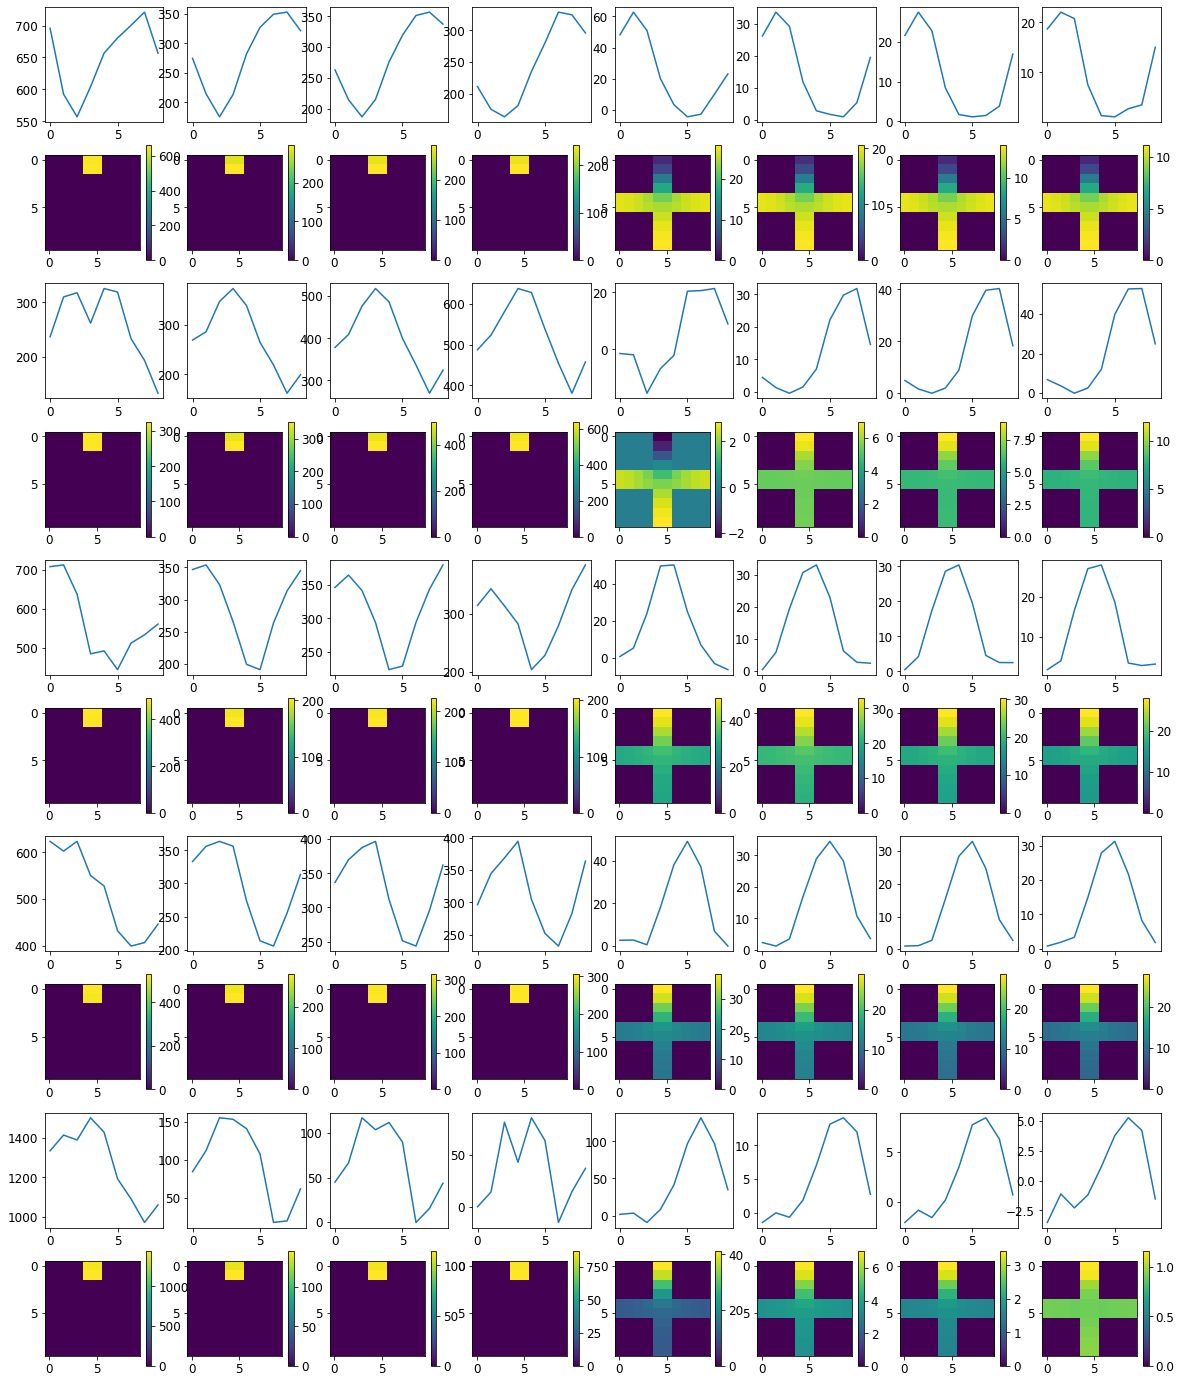

Loss: 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


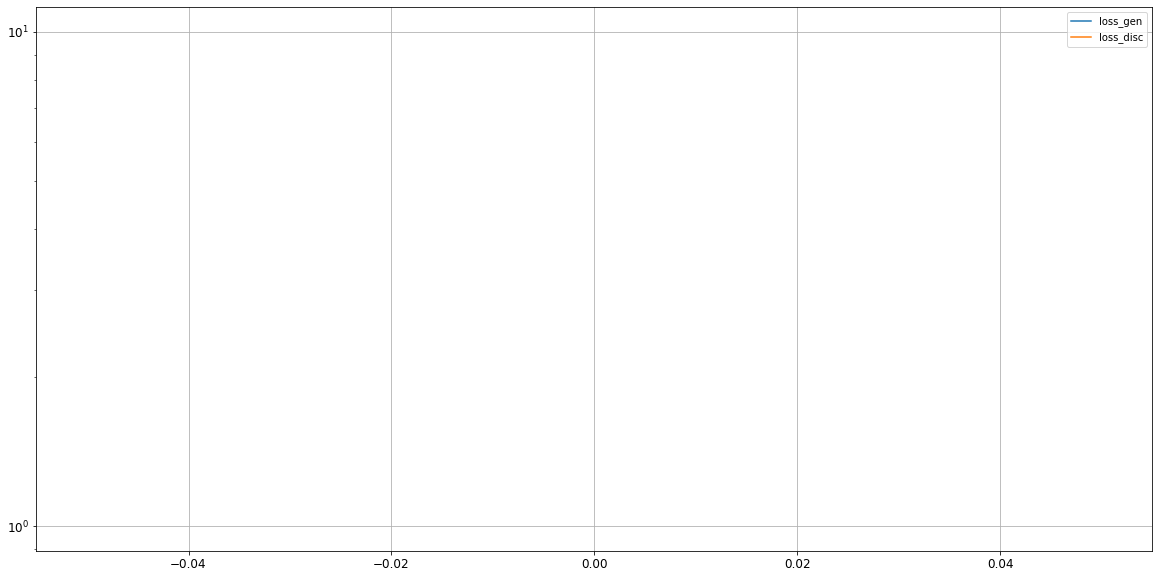

Epoch 2/10000
discriminator: -0.000847 - generator: -0.008892 - 3s
Epoch 3/10000
discriminator: -0.000962 - generator: -0.008777 - 3s
Epoch 4/10000
discriminator: -0.000666 - generator: -0.008959 - 3s
Epoch 5/10000


KeyboardInterrupt: 

In [24]:
hist = train(train_dataset, epochs=10000)

# Predictions

In [25]:
#weight = tf.constant(np.ones(15), dtype=tf.float32)
weight = tf.constant(pca_compressed.singular_values_, dtype=tf.float32)
#weight = tf.constant(pca_compress.explained_variance_, dtype=tf.float32)
weight

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([8.0968852e+04, 1.8736416e+04, 1.3673706e+04, 5.5826768e+03,
       3.8501030e+03, 1.8000193e+03, 1.5285522e+03, 1.2805509e+03,
       7.3294604e+02, 4.3526801e+02, 2.9716446e+02, 1.8160262e+02,
       8.7675873e+01, 6.4752045e+01, 5.6145763e+01], dtype=float32)>

In [26]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    return mse(inp, outp)

In [27]:
#@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [28]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
#     latent_values = tf.random.normal([len(real_coding), latent_size])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
                            
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [29]:
n = 2000
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

Loss:  4.560509
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[ 0.18118542, -0.2370644 , -0.11969051,  0.11950037, -0.1756236 ,
         0.10989887, -0.0676868 ,  0.78215986,  0.04259782, -0.18090916,
        -0.29661205,  0.5388214 ,  0.1367356 ,  0.19872016,  0.7644309 ,
         0.01414779,  0.00911363, -0.10151155,  0.5199278 ,  0.23575476,
         0.01501715, -0.10464784,  0.22874136,  0.06829002,  0.24758343,
         0.02773511, -0.04310422,  0.19908996,  0.08701698,  0.00370853,
         0.0923152 , -0.3643304 ,  0.40025234,  0.05513985, -0.11440859,
        -0.14376454,  0.05911085,  0.33729705, -0.19194949, -0.03740781,
         0.35738993, -0.00159879,  0.1428571 , -0.00290415, -0.26603344,
        -0.14129673, -0.01154656,  0.02233421, -0.14667964, -0.15962978,
         0.05505646,  0.04908415,  0.04660902, -0.14742212, -0.05105136,
        -0.14731622,  0.25269175, -0.01139148, -0.31571466,  0.19997987,
         0.01004707,  0.42304856,  0.35093212

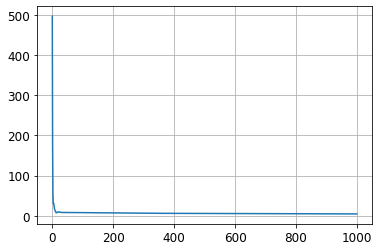

In [30]:
latent_size = 100
latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
print(latent_values)

In [31]:
X_generated = scaler.inverse_transform((generator.predict(tf.convert_to_tensor(latent_values)).reshape(ntimes,codings_size)+1)/2)
X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(ntimes, len(groups)*nl*nc)

In [32]:
X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes,codings_size)+1)/2)
X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(ntimes, len(groups)*nl*nc)

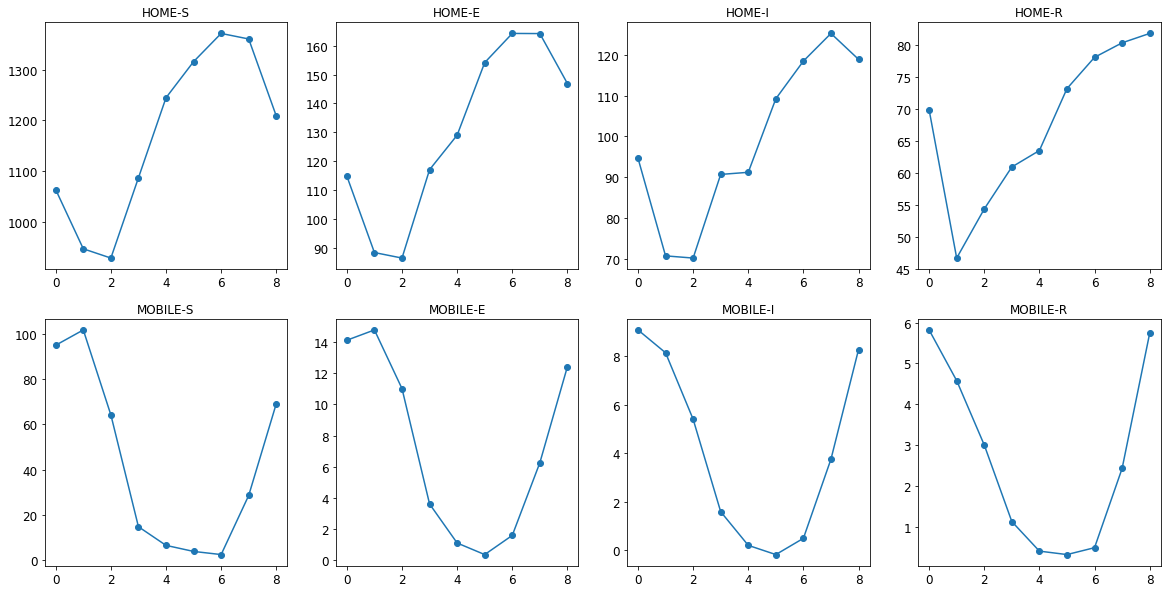

In [33]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata.png')

### predicting multiple points

In [34]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  #returns the optimized input that generates the desired output

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

latent_size = 100
n = 2000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

# latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

# latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
# X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
# gen_predict = X_predict[-1]
# read_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:, codings_size:]
# real_coding = tf.constant(real_coding)
# real_coding = tf.cast(real_coding, dtype=tf.float32)

X_predict = list(X_train_concat[n,:-1])
for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [36]:
X_generated1 = scaler.inverse_transform((X_predict+1)/2)
X_generated1 = pca_compressed.inverse_transform(X_generated1)
X_generated1 = X_generated1.reshape(len(X_predict), len(groups)*nl*nc)
X_generated1[X_generated1<0] = 0 

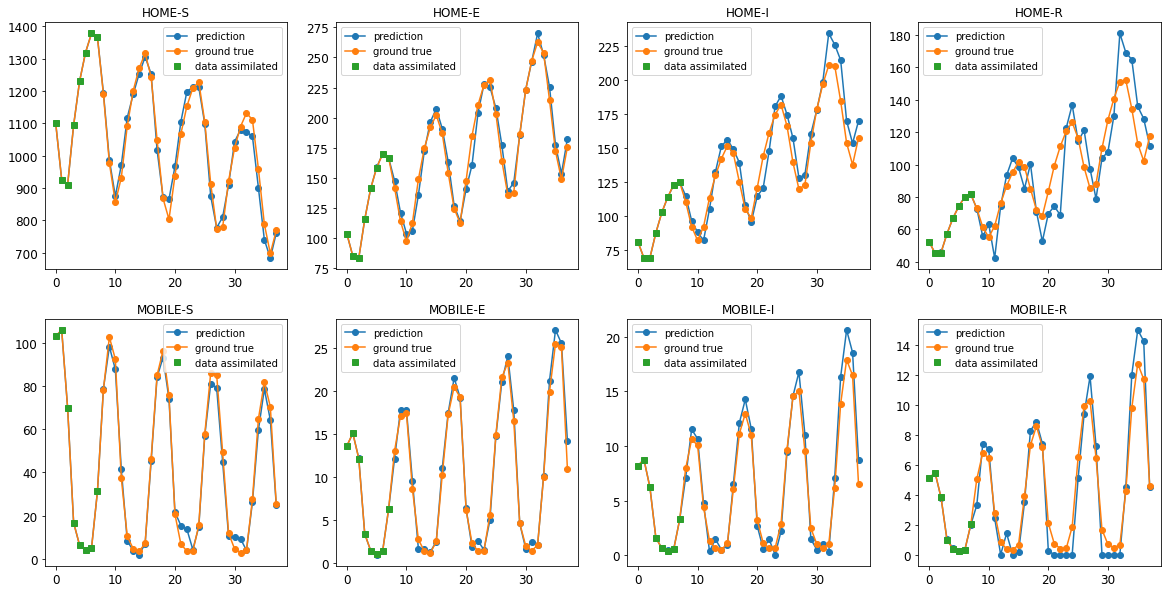

In [37]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated1[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')